In [ ]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [ ]:
class AgentState(TypedDict):
  message : str

def greeting_node(state: AgentState) -> AgentState:
  """Simple node that adds a greeting message to the state"""

  state['message'] = "Hey" + state["message"] + ", how is your day going?"

  return state

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)

graph.set_entry_point("greeter")

graph.set_finish_point("greeter")

app = graph.compile()



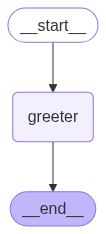

In [ ]:
from IPython.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({"message": "Bob"})

In [ ]:
result

{'message': 'HeyBob, how is your day going?'}

In [ ]:
from typing import Dict, TypedDict,List

class AgentState(TypedDict):
  values: List[int]
  name: str
  result: str

In [ ]:
def process_values(state: AgentState) -> AgentState:
    """This function handles multiple different inputs"""
    print(state)

    state["result"] = f"Hi there {state['name']}! Your sum = {sum(state['values'])}"

    print(state)
    return state

In [ ]:
graph = StateGraph(AgentState)

graph.add_node("processor", process_values)
graph.set_entry_point("processor") # Set the starting node
graph.set_finish_point("processor") # Set the ending node

app = graph.compile() # Compiling the graph

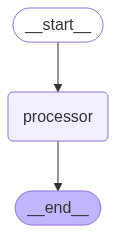

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
answers = app.invoke({"values": [1,2,3,4], "name": "Steve"})

{'values': [1, 2, 3, 4], 'name': 'Steve'}
{'values': [1, 2, 3, 4], 'name': 'Steve', 'result': 'Hi there Steve! Your sum = 10'}


In [ ]:
!pip install langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')


In [ ]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END

In [ ]:
class AgentState(TypedDict):
  messages: List[HumanMessage]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [ ]:
def process(state: AgentState) -> AgentState:
  response = llm.invoke(state["messages"])
  print(response.content)
  state["messages"].append(HumanMessage(content=response.content))
  return state


In [ ]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

agent = graph.compile()

In [ ]:
user_input = input("Enter :")
agent.invoke({"messages": [HumanMessage(content=user_input)]})

Enter :exit
Understood. If you're finished with our conversation, you can simply stop typing or close your browser tab/application.

Is there anything else I can assist you with before you go?


{'messages': [HumanMessage(content='exit', additional_kwargs={}, response_metadata={}),
  HumanMessage(content="Understood. If you're finished with our conversation, you can simply stop typing or close your browser tab/application.\n\nIs there anything else I can assist you with before you go?", additional_kwargs={}, response_metadata={})]}

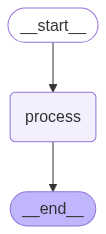

In [ ]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

**Memory Agent**

In [ ]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END


In [ ]:
class AgentState(TypedDict):
  messages: List[Union[HumanMessage, AIMessage]]

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [ ]:
def process(state: AgentState) -> AgentState:
  """ This node will solve the request to input """
  response = llm.invoke(state["messages"])
  state["messages"].append(AIMessage(content=response.content))
  print(response.content)
  return state

In [ ]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)

agent = graph.compile()

conversation_history = []

In [ ]:
user_input = input("Enter :")

while user_input != "exit":
  conversation_history.append(HumanMessage(content=user_input))
  result = agent.invoke({"messages": conversation_history})
  conversation_history.append(result["messages"][-1])
  user_input = input("Enter :")

Enter :exit


ReAct - Reasoning and Acting Agent

In [ ]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage # The foundational class for all message types in LangGraph
from langchain_core.messages import ToolMessage # Passes data back to LLM after it calls a tool such as the content and the tool_call_id
from langchain_core.messages import SystemMessage # Message for providing instructions to the LLM
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_google_genai import ChatGoogleGenerativeAI


In [ ]:
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool
def add(a: int, b:int):
    """This is an addition function that adds 2 numbers together"""

    return a + b

@tool
def subtract(a: int, b: int):
    """Subtraction function"""
    return a - b

@tool
def multiply(a: int, b: int):
    """Multiplication function"""
    return a * b

In [ ]:
tools = [add, subtract, multiply]

In [ ]:
pip install -q langchain langchain-google-genai pydantic

In [ ]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0).bind_tools(tools)


In [ ]:
def model_call(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content =  "You are my AI assistant, please answer my query to the best of your ability.")
  response = model.invoke([system_prompt] + state["messages"])
  # state["messages"].append(response)
  return { "messages" : [response]};

In [ ]:
tool_node = ToolNode(tools=tools)


In [ ]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

# --- 5. Build the Graph ---
# The graph structure is identical.
graph = StateGraph(AgentState)

graph.add_node("our_agent", model_call)
graph.add_node("tools", tool_node)

graph.set_entry_point("our_agent")

In [ ]:
graph.add_conditional_edges(
    "our_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)


In [ ]:
graph.add_edge("tools", "our_agent")


In [ ]:
app = graph.compile()


In [ ]:
def print_stream(stream):
    for s in stream:
        # `s` is the full state of the graph. We print the last message added.
        message = s["messages"][-1]
        message.pretty_print()

In [ ]:
inputs = {"messages": [("user", "Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.")]}
print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and then multiply the result by 6. Also tell me a joke please.
================================== Ai Message ==================================
Tool Calls:
  add (24fb4d80-11c6-4fbc-8ba9-22450f243afd)
 Call ID: 24fb4d80-11c6-4fbc-8ba9-22450f243afd
  Args:
    a: 40.0
    b: 12.0
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================
Tool Calls:
  multiply (f590990a-9839-41a2-b43e-a330d7ec7ab1)
 Call ID: f590990a-9839-41a2-b43e-a330d7ec7ab1
  Args:
    a: 52.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

312
================================== Ai Message ==================================

The sum of 40 and 12 is 52. When 52 is multiplied by 6, the result is 312.

Here's a joke for you: Why don't scientists trust a

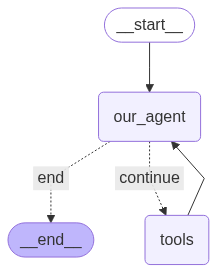

In [ ]:
from IPython.display import Image, display

# Ensure you are calling get_graph() on your compiled LangGraph application
# which we named 'app'.
try:
    # Get the graph object
    graph = app.get_graph()

    # Draw the graph to a PNG byte string
    png_bytes = graph.draw_mermaid_png()

    # Display the image
    display(Image(png_bytes))

except ImportError as e:
    print(f"ImportError: {e}")
    print("Please install pygraphviz: pip install pygraphviz")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure that the Graphviz system library is installed and in your PATH.")
    print("See installation instructions at: https://graphviz.org/download/")

In [ ]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END

In [ ]:
document_content = ""
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
@tool
def update(content: str) -> str:
  """ Update documents with the provided content."""
  global document_content
  document_content = content
  return f"Document has been updated successfully! The current content is:\n{document_content}"

@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.

    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"


    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."

    except Exception as e:
        return f"Error saving document: {str(e)}"


tools = [update, save]

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0).bind_tools(tools)


def our_agent(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content = f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.

    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is:{document_content}
    """)
  if not state["messages"]:
    user_input = "I'm ready to help you update a document. What would you like to create?"
    user_message = HumanMessage(content=user_input)

  else:
     user_input = input("\nWhat would you like to do with the document? ")
     print(f"\n👤 USER: {user_input}")
     user_message = HumanMessage(content=user_input)

  all_messages = [system_prompt] + list(state["messages"]) + [user_message]
  response = model.invoke(all_messages)

  print(f"\n🤖 AI: {response.content}")
  if hasattr(response, "tool_calls") and response.tool_calls:
      print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

  return {"messages": list(state["messages"]) + [user_message, response]}



def our_agent(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content = f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.

    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is:{document_content}
    """)
  if not state["messages"]:
    user_input = "I'm ready to help you update a document. What would you like to create?"
    user_message = HumanMessage(content=user_input)

  else:
     user_input = input("\nWhat would you like to do with the document? ")
     print(f"\n👤 USER: {user_input}")
     user_message = HumanMessage(content=user_input)

  all_messages = [system_prompt] + list(state["messages"]) + [user_message]
  response = model.invoke(all_messages)

  print(f"\n🤖 AI: {response.content}")
  if hasattr(response, "tool_calls") and response.tool_calls:
      print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

  return {"messages": list(state["messages"]) + [user_message, response]}

tool_node = ToolNode(tools=tools)

def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]

    if not messages:
        return "continue"

    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint

    return "continue"

def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return

    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")



In [ ]:
def our_agent(state: AgentState) -> AgentState:
  system_prompt = SystemMessage(content = f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.

    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.

    The current document content is:{document_content}
    """)
  if not state["messages"]:
    user_input = "I'm ready to help you update a document. What would you like to create?"
    user_message = HumanMessage(content=user_input)

  else:
     user_input = input("\nWhat would you like to do with the document? ")
     print(f"\n👤 USER: {user_input}")
     user_message = HumanMessage(content=user_input)

  all_messages = [system_prompt] + list(state["messages"]) + [user_message]
  response = model.invoke(all_messages)

  print(f"\n🤖 AI: {response.content}")
  if hasattr(response, "tool_calls") and response.tool_calls:
      print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

  return {"messages": list(state["messages"]) + [user_message, response]}

graph = StateGraph(AgentState)

graph.add_node("agent", our_agent)
graph.add_node("tools", tool_node)

graph.set_entry_point("agent")

graph.add_edge("agent","tools")

graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)


app = graph.compile()

def run_document_agent():
    print("\n ===== DRAFTER =====")

    state = {"messages": []}

    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])

    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()



 ===== DRAFTER =====

🤖 AI: I'm ready to help you update a document. What would you like to change in the current document?

What would you like to do with the document? tell me about react js

👤 USER: tell me about react js

🤖 AI: I am sorry, but I cannot tell you about React JS. My purpose is to help you update and modify documents.

The current document content is:
Subject: Unavailability for Meeting

Hi John,

I hope this email finds you well.

I am writing to inform you that I will not be available for the upcoming meeting. I apologize for any inconvenience this may cause. I will be available after August 18th, 1 PM.

Please let me know if there are any key points or decisions from the meeting that I should be aware of.

Thank you for your understanding.

Best regards,

Ash

What would you like to change in the current document?

What would you like to do with the document? change time to 19 august 1 am

👤 USER: change time to 19 august 1 am

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ 